<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/full_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# 1. Set up project in runtime
Copy the following cell and run it with your credentials to clone the repo, getting datasets as runtime files, and then delete your credentials.

In [2]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.


'/content'

# 2. Preprocess data

Datasets:
- `largeset_multisize_v2`
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 16706 Images, in randomized order
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)


In [3]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [4]:
training_proportion = 0.8
validation_proportion = 0.0

def load_and_partition(path):
  arr = make_image_arr(path)
  cutoff = int(len(arr)*training_proportion)
  return arr[:cutoff], arr[cutoff:]

def make_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))

color_train, color_test = load_and_partition('/content/CPSC-440-Project/datasets/largeset_multisize_v2/color')
gray_train, gray_test = load_and_partition('/content/CPSC-440-Project/datasets/largeset_multisize_v2/gray')

assert(len(color_train) == len(gray_train) and len(color_test) == len(gray_test))
n_train = len(color_train)
n_test = len(color_test)

color_train_tensors = make_tensor(color_train)
color_test_tensors = make_tensor(color_test)

gray_train_tensors = make_tensor(gray_train)
gray_test_tensors = make_tensor(gray_test)

100%|██████████| 16706/16706 [00:05<00:00, 2815.33it/s]


685


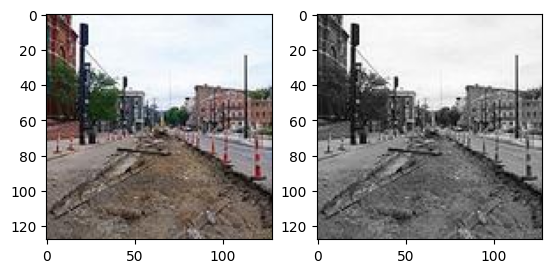

7322


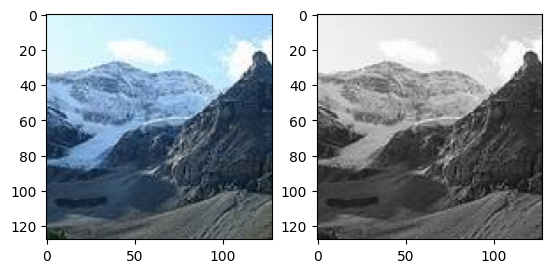

11620


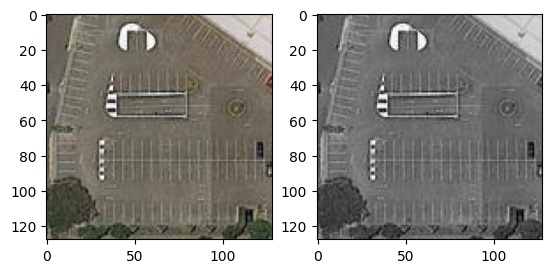

In [5]:
for i in np.random.randint(n_train,size=3):
  print(i)
  plt.subplot(1,2,1)
  plt.imshow(color_train[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_train[i])
  plt.show()

# 3. Model
Model generated below:

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Train Model (SGD)

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_epochs = 100
num_iterations = 1000
batch_size=32
for epoch in range(num_epochs):
  for iteration in range(num_iterations):
      running_loss = 0.0
      batch_indexes = torch.randint(high=n_train, size=(batch_size,1))

      inputs = gray_train_tensors[batch_indexes].squeeze().to(device)
      targets = color_train_tensors[batch_indexes].squeeze().to(device)

      outputs = autoencoder(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.5f' % (epoch+1, running_loss / batch_size))

print('Finished Training')

[1] loss: 0.00034
[2] loss: 0.00031
[3] loss: 0.00024
[4] loss: 0.00030
[5] loss: 0.00027
[6] loss: 0.00022
[7] loss: 0.00024
[8] loss: 0.00017
[9] loss: 0.00025
[10] loss: 0.00021
[11] loss: 0.00023
[12] loss: 0.00021
[13] loss: 0.00020
[14] loss: 0.00024
[15] loss: 0.00017
[16] loss: 0.00013
[17] loss: 0.00020
[18] loss: 0.00019
[19] loss: 0.00020
[20] loss: 0.00020
[21] loss: 0.00019
[22] loss: 0.00016
[23] loss: 0.00019
[24] loss: 0.00023
[25] loss: 0.00017
[26] loss: 0.00016
[27] loss: 0.00019
[28] loss: 0.00016
[29] loss: 0.00020
[30] loss: 0.00017
[31] loss: 0.00022
[32] loss: 0.00017
[33] loss: 0.00020
[34] loss: 0.00017
[35] loss: 0.00018
[36] loss: 0.00018
[37] loss: 0.00015
[38] loss: 0.00019
[39] loss: 0.00016
[40] loss: 0.00017
[41] loss: 0.00014
[42] loss: 0.00017
[43] loss: 0.00021
[44] loss: 0.00013
[45] loss: 0.00014
[46] loss: 0.00012
[47] loss: 0.00023
[48] loss: 0.00013
[49] loss: 0.00014
[50] loss: 0.00016
[51] loss: 0.00013
[52] loss: 0.00017
[53] loss: 0.00015
[5

Simple Image Space Exploration

tensor(0.0090, grad_fn=<MseLossBackward0>)


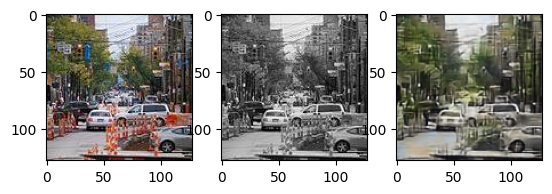

tensor(0.0106, grad_fn=<MseLossBackward0>)


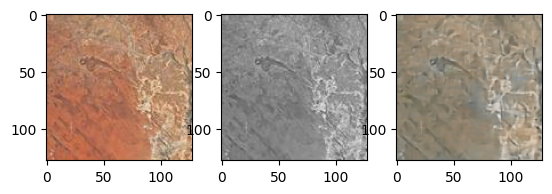

tensor(0.0023, grad_fn=<MseLossBackward0>)


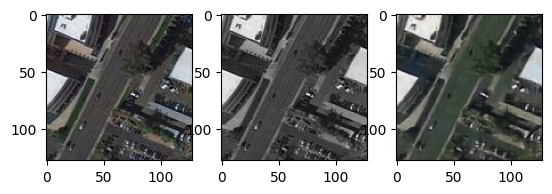

In [41]:
autoencoder.eval()
for i in np.random.randint(n_train,size=3):
  image_bw = gray_train[i]
  image_c = color_train[i]

  # Colorize the image
  t = gray_train_tensors[i].to(device)
  colorized_image = autoencoder(t)
  colorized_image_format = np.moveaxis(colorized_image.cpu().detach().numpy(), [1,2], [0,1])

  print(nn.MSELoss()(colorized_image.cpu(), color_train_tensors[i]))

  plt.subplot(1,3,1)
  plt.imshow(image_c)
  plt.subplot(1,3,2)
  plt.imshow(image_bw)
  plt.subplot(1,3,3)
  plt.imshow(colorized_image_format)
  plt.show()

# LEFT TO RIGHT: ORIGINAL, GRAYSCALE, COLORIZED

# Visualize model

Using [pytorchviz](https://github.com/szagoruyko/pytorchviz)!

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot
make_dot(colorized_image.mean(), params=dict(autoencoder.named_parameters()))

In [23]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/models/decoder_weights_2')

In [24]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/models/full_size_encoder_weights_2')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [15]:
cd CPSC-440-Project

/content/CPSC-440-Project


In [26]:
!git add .

In [31]:
!git status

On branch main
Your branch and 'origin/main' have diverged,
and have 2 and 1 different commits each, respectively.
  (use "git pull" to merge the remote branch into yours)

nothing to commit, working tree clean


In [27]:
!git commit -m "Final full size model weights"

[main a74abf983] Final full size model weights
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 models/decoder_weights_2
 create mode 100644 models/full_size_encoder_weights_2


In [35]:
!git push

Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 12 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 1.98 MiB | 2.01 MiB/s, done.
Total 10 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 1 local object.
To https://github.com/StuartLiv/CPSC-440-Project
 + 3d362565c...a74abf983 main -> main (forced update)


In [40]:
autoencoder.decoder = torch.load('/content/CPSC-440-Project/models/decoder_weights')

autoencoder.encoder = torch.load('/content/CPSC-440-Project/models/full_size_encoder_weights') # need some weights saved here!

# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!